# <b>INTRODUCTION</b>

This document represents a small introduction on how to do and what to look for when doing spectral clustering. <br>
Starting from either one of this three files: <em>Spiral.csv, Circle.csv</em> or <em>3d_rings.csv</em>.<br>
We are going to implement spectral clustering: moreover, we will be building the similarity matrix $W$ the distance matrix $D$ and the Laplacian matrix $L$.<br>
Then, we will evaluate eigenvectors and eigenvalues of $L$, compute $U$, and finally clusterize the starting points.
<br><br>
<b>The authors of the following files are:
- Nunzio Licalzi, s344860
- Romeo Vercellone, s341967</b>

# <b>MODULES AND CONSTANTS</b>

### <b>MODULES AND LIBRARIES</b>

In [711]:
# GENERAL IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from scipy.linalg import eigh, null_space


# PLOTTING IMPORT
import matplotlib.colors as colors
import matplotlib.cm as cm
from IPython.display import display, Math


# DISTANCE FUNCTION
from sklearn.metrics.pairwise import rbf_kernel


# CLUSTERING ALGORITHMS
from sklearn.cluster import DBSCAN, BisectingKMeans, KMeans, SpectralClustering


# METRICS
from sklearn.metrics import silhouette_score, accuracy_score

### <b>CONSTANTS</b>

In [712]:
SPIRAL_INPUT_FILE = 'Spiral.csv'
CIRCLE_INPUT_FILE = 'Circle.csv'
RINGS_3D_INPUT_FILE = '3d_rings.csv'
EPS = 1e-24
NEIGHBORS = 10      # number of neighbors to consider for spectral clustering when building the similarity matrix
EIGENPAIRS = 10     # number of eigenpairs to compute
USE_SPIRAL = True   # use spiral.csv file or circle.csv file
np.random.RandomState(23);      # for reproducibility 

# ENABLES THE COMPARISON BETWEEN EIGENPAIRS FUNCTION IN THE FILE
ENABLE_COMPARISON = False # HEAVILY ADVISED TO KEEP THIS TO FALSE

# <b>0 - READ FUNCTIONS</b>

### <b>readSpiralInput</b>
reads the input file containing the spiral data, 
<br> accepts as input the path to the csv file containing the data
<br> returns a pandas dataFrame

In [713]:
def readSpiralInput(path: str = SPIRAL_INPUT_FILE) -> pd.DataFrame:
    """
    Reads the input file containing the spiral data.

    Parameters:
    path (str): The path to the CSV file containing the data. Defaults to SPIRAL_INPUT_FILE.

    Returns:
    pd.DataFrame: A pandas DataFrame with columns 'x', 'y', and 'cluster' representing the spiral data.
    """
    return pd.read_csv(filepath_or_buffer=path, header=None).set_axis(labels=['x', 'y', 'cluster'], axis=1)

### <b>readCircleInput</b>
reads the input file containing the circle data
<br> accepts as input the path to the csv file containing the data
<br> returns a pandas dataFrame

In [714]:
def readCircleInput(path: str = CIRCLE_INPUT_FILE) -> pd.DataFrame:
    """
    Reads the input file containing the circle data.

    Parameters:
    path (str): The path to the CSV file containing the data. Defaults to CIRCLE_INPUT_FILE.

    Returns:
    pd.DataFrame: A pandas DataFrame with columns 'x' and 'y' representing the circle data.
    """
    return pd.read_csv(filepath_or_buffer=path, header=None).set_axis(labels=['x', 'y'], axis=1)

We can print the data (since we are dealing with 2D points) to understand the spacial placement of the points and to discuss the most suited cluster algorithm

In [715]:
def plotPoint(points: pd.DataFrame, title: str = None) -> None:
    """
    Plots 2D points from a DataFrame, optionally coloring them by cluster.

    Parameters:
    points (pd.DataFrame): A DataFrame containing the points to plot. 
                           It must have columns 'x' and 'y'. 
                           If a 'cluster' column is present, points will be colored by cluster.
    title (str, optional): The title of the plot. Defaults to 'Points' if not provided.
    """
    plt.subplots(1, 1, figsize=(8, 8))
    
    if 'cluster' in points.columns:
        plt.gca().add_artist(plt.legend(
            *plt.scatter(points['x'], points['y'], c=points['cluster'], cmap='viridis').legend_elements(), title="Clusters"))
    else:
        plt.scatter(points['x'], points['y'], color='blue', label='Points')
    
    plt.title(title or 'Points')
    plt.xlabel('x'),plt.ylabel('y')
    plt.show()

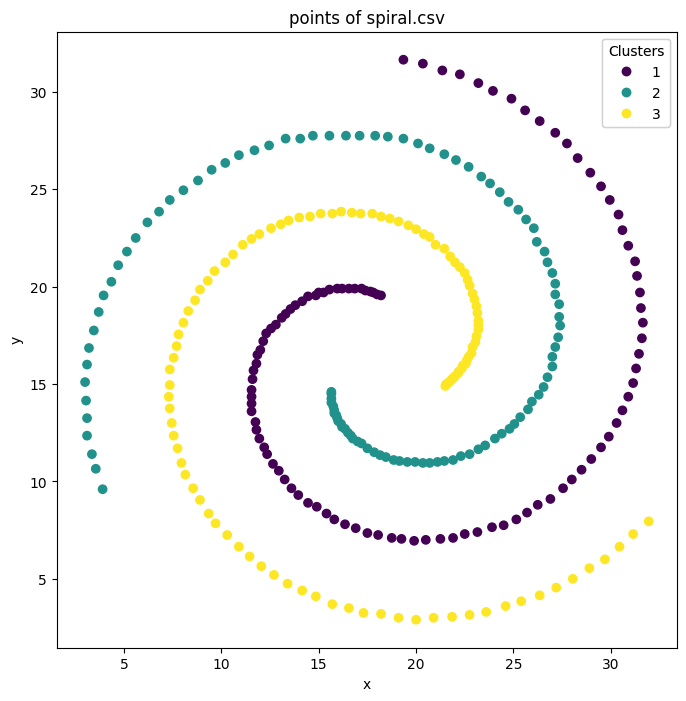

In [716]:
data = readSpiralInput(SPIRAL_INPUT_FILE) if USE_SPIRAL else readCircleInput(CIRCLE_INPUT_FILE)
plotPoint(data, title='points of ' + 'spiral.csv' if USE_SPIRAL else 'Circle.csv')

# <b>1 - BUILDING $W$ SIMILARITY MATRIX </b>

Given a set of data points X and the similarity function:
$ s_{i, j} = exp\left( - \frac{||X_i - X_j||^2}{2\sigma^2}\right)$

construct the <em>k-nearest neighborhood</em> similarity graph and its adjacency
matrix $W$ using $\sigma = 1$.

In [717]:
def buildSimilarityMatrix(circle: pd.DataFrame, k: int = NEIGHBORS, sigma: int = 1)->np:
    """
    Constructs a k-nearest neighborhood similarity graph and its adjacency matrix W.

    Parameters:
    circle (pd.DataFrame): A DataFrame containing the data points. It should have columns representing the coordinates of the points.
    k (int): The number of nearest neighbors to consider for each point. Defaults to the global constant NEIGHBORS.
    sigma (int): The parameter for the RBF kernel, controlling the width of the Gaussian. Defaults to 1.

    Returns:
    np.ndarray: A symmetric matrix representing the similarity graph, where each element (i, j) indicates the similarity between points i and j.
    """
    
    matrix = rbf_kernel(circle[circle.columns.difference(['cluster'])], gamma=sigma/2)
    np.fill_diagonal(matrix, 0)

    mask = np.zeros(matrix.shape, dtype=bool)
    mask[np.arange(matrix.shape[0])[:, None], np.argpartition(-matrix, k, axis=1)[:, :k]] = True

    matrix = np.where(mask, matrix, 0)
    
    for i in range(matrix.shape[0]):
        for j in range(matrix[i, :].shape[0]):
            if matrix[i, j] > EPS:
                matrix[j, i] = matrix[i, j]
    
    return matrix

W = buildSimilarityMatrix(data[['x', 'y']], NEIGHBORS)

<h4><b>Symmetry problem</b></h4>
The main problem that may occur when building this matrix is related to the required symmetry. 

Moreover, the given matrix $W$ must be symmetric since we are dealing with a weighted, non-oriented graph. <br>
However, this may not always be the case because, even if weights are computed symmetrically (i.e., $\forall i,j, s_{i,j} = s_{j,i}$), considering the $k-nearest \text{ }neighbors$ may create asymmetry:  
If a vertex $V$ is a neighbor of $V'$, we cannot be sure of the opposite, as shown here.<br>
<img src='./pictures/output.png' alt='KNN problem'></img>
<br>
To address this issue, we can use one of two approaches (relaxing the constraint of having exactly $k$ neighbors):
<ul>
    <li>Impose that if <em>V</em> is a neighbor of <em>V'</em>, then <em>V'</em> is also a neighbor of <em>V</em>, thus potentially allowing more than <em>k</em> neighbors for a single vertex.</li>
    <li>Impose that if <em>V</em> is not a neighbor of <em>V'</em>, then <em>V'</em> is also not a neighbor of <em>V</em>, thus potentially allowing fewer than <em>k</em> neighbors for a single vertex.</li>
</ul>
We have chosen the first approach.

# <b>2 - BUILD DEGREE MATRIX $D$ AND LAPLACIAN MATRIX $L$</b>

Construct the degree diagonal matrix $D$ where each diagonal entry is obtained by summing the respective row of the similarity matrix $W$.<br>
$$D_{i,i} = \sum_{j=1}^N W_{i,j}$$

In [718]:
def buildDegreeMatrix(matrix: np) -> np:
    """
    Constructs the degree matrix for a given adjacency matrix.

    Parameters:
    matrix (np.ndarray): A 2D numpy array representing the adjacency matrix of a graph.

    Returns:
    np.ndarray: A diagonal matrix where each diagonal element represents the degree of the corresponding vertex.
    """
    return np.diag(matrix.sum(axis=1))

Construct the <b>Laplacian matrix</b> $L = D − W$.<br>
Note: we can also build the <b>normalized symmetric Laplacian matrix</b>
$L_{sym} \in R^{N,N}$ that is defined as $ L_{sym} := D ^{− \frac{1}{2}} LD^{−\frac{1}{2}} = I − D^{-\frac{1}{2}}WD^{-\frac{1}{2}}$

In [719]:
def buildLaplacianMatrix(D: np, W: np, computeNormalizedLaplacian: bool = False) -> np:
    """
    Constructs the Laplacian matrix for a given graph.

    Parameters:
    D (np.ndarray): The degree matrix of the graph, which is a diagonal matrix where each diagonal element 
                    represents the degree of the corresponding vertex.
    W (np.ndarray): The adjacency matrix of the graph, representing the similarity between nodes.
    computeNormalizedLaplacian (bool): A flag indicating whether to compute the normalized Laplacian matrix. 
                                        Defaults to False, which computes the unnormalized Laplacian.

    Returns:
    np.ndarray: The Laplacian matrix of the graph. If computeNormalizedLaplacian is False, it returns the 
                unnormalized Laplacian (D - W). If True, it returns the normalized Laplacian.
    """
    if not computeNormalizedLaplacian:
        return D - W

    D[np.diag_indices(n=D.shape[0])] **= -1 / 2
    return np.eye(N=D.shape[0]) - D @ W @ D

### <b>setAsSparseMatrix</b>
Given a matrix as input, returns the same matrix in a sparse format. <br>
We have chosen to use an approach similar to the <b>modified CSR sparse format</b> to prioritize the diagonal of the matrix. <br>
Which is particularly convenient when dealing with matrices such as the degree matrix $D$. 

In [720]:
def setAsSparseMatrix(matrix: np, method: sparse.dia_array | None = sparse.dia_array) -> sparse:
    """
    Converts a given matrix into a sparse format using the specified method.

    Parameters:
    matrix (np.ndarray): The matrix to be converted into a sparse format.
    method (sparse.dia_array or None): The sparse format method to use for conversion. 
                                       Defaults to sparse.dia_array if not specified.

    Returns:
    sparse: The matrix converted into the specified sparse format.
    """
    return method(matrix)

Finally, the Laplacian matrix is built using the previously declared function. <br>
Moreover, since we will only be working with $L$ from now on, we can convert $D$ and $W$ into a sparse matrix format. <br>
We prefer not to convert $L$ since it will still be used for many different purposes. <br>
Due to the structure of $W$ we opted to convert it into a modified CSR format, whilst we only store the diagonal of D.

In [721]:
L = buildLaplacianMatrix(D:=buildDegreeMatrix(W), W, computeNormalizedLaplacian=False)
D, W = D[np.diag_indices(D.shape[0])], setAsSparseMatrix(W, method=sparse.csr_matrix)

# We can also check if we have compute correctly the normalized laplacian
print(f'{"NOT" if any(np.unique(L[np.diag_indices(L.shape[0])]) != 1) else ""} Normalized Laplacian')

NOT Normalized Laplacian


# <b>3 - CONNECTED COMPONENT OF THE GRAPHS </b>

Compute the number of connected components of the similarity graph.

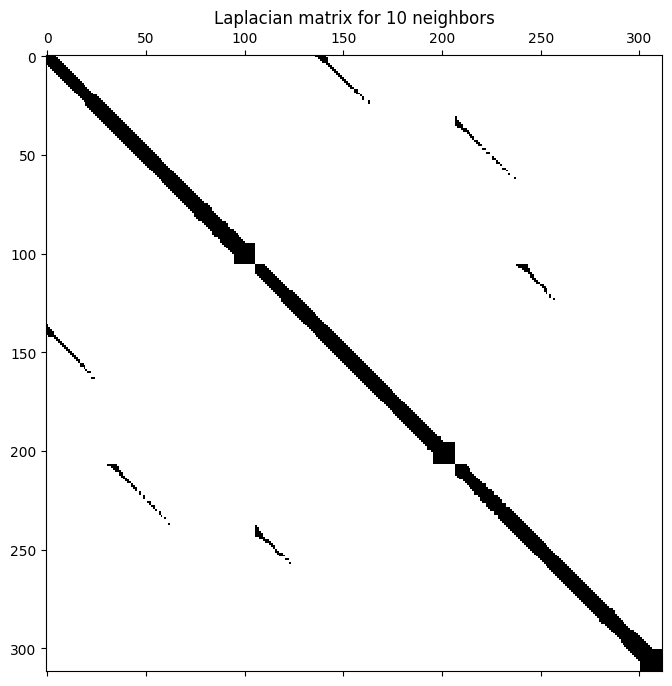

In [722]:
def plotLaplacian(L: np) -> None:
    """
    Plots the sparsity pattern of the Laplacian matrix.

    Parameters:
    L (np.ndarray): The Laplacian matrix to be visualized. It is expected to be a 2D numpy array.

    """
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.spy(L)
    ax.set_title(f'Laplacian matrix for {NEIGHBORS} neighbors')
    plt.show()
    
plotLaplacian(L)

First and foremost, as expected, the Laplacian matrix $L$ is symmetric. <br>
Moreover, it is a sparse matrix, with most of the non-zero elements located near the main diagonal. <br>
Finally, and most importantly, we can conclude that the graph is primarily composed of three main components (represented by the three blocks along the diagonal), which are weakly connected, as indicated by the small black patches far from the main diagonal.

# <b>4/5 - EIGENVALUES AND EIGENVECTORS OF $L$</b>

Compute some of the small eigenvalues of $L$ and use their values to choose a suitable number of clusters $M$ for the data points. <br>
From what we have previously observed, we can conclude that the graph has $3$ main components. <br>
However, we are going to compute the first $10$ eigenvalues, mainly because the graph also shows $6$ more patches with non-zero values (even though the patches are symmetric), indicating a weak connection between the $3$ main components of the graph.

## <b>USING SCIPY IMPLEMENTATION</b>

We can easily compute eigenvalues using the eigh function within scipy.

Computed the following 10 eigenvalues


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

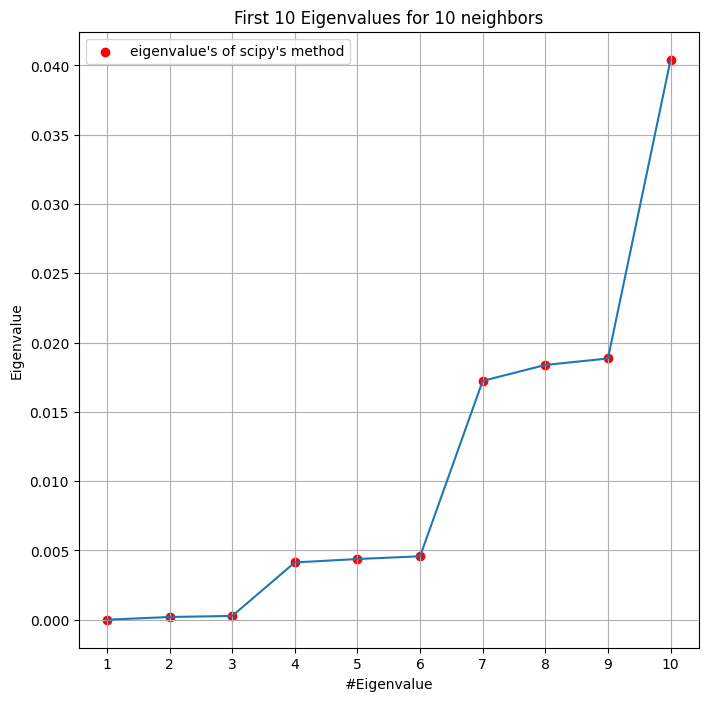

In [723]:
def printEigenValues(eigVal: np, legendText: str) -> None:
    """
    Plots and displays the eigenvalues of a matrix.

    Parameters:
    eigVal (np.ndarray): An array of eigenvalues to be plotted and displayed.
    legendText (str): A string to be used as the legend label for the plot.

    """
    n = eigVal.shape[0]
    print(f"Computed the following {n} eigenvalues")
    for i, item in enumerate(eigVal):
        display(Math(rf"\hspace{{2em}}\lambda_{{{i+1}}} = {item}"))

    plt.subplots(1, 1, figsize=(8, 8))
    plt.plot(values := range(1, n + 1), eigVal)
    plt.scatter(values, eigVal, c='red', label=legendText)
    plt.xticks(values)
    plt.ylabel("Eigenvalue"), plt.xlabel('#Eigenvalue')
    plt.title(f"First {n} Eigenvalues for {NEIGHBORS} neighbors")
    plt.legend(loc='upper left')
    plt.grid(visible=True)
    plt.show()
    
printEigenValues(eigh(L,subset_by_index=[0, 9],eigvals_only=True), "eigenvalue's of scipy's method")

## <b>INVERSE POWER METHOD</b>

To evaluate the eigenvalues we can also implement the <b>inverse power method</b> algorithm. 
<h4><b>Theoretical aspects</b></h4>

Let $A \in R^{n,n}$, we can define $\lambda_n$ as the eigenvalue of A with smallest magnitude (i.e. $|\lambda_n| \leq |\lambda_i|, \forall i \in [1,n]$). <br>
Moreover, assuming A is invertible (and this is our case) we have that the eigenvalues of the inverse of A are the inverse of the eigenvalues of the matrix A <br>(i.e. $\forall i \in [1, n], Ax_i = \lambda_i x_i \implies A^{-1}x_i = \frac{1}{\lambda_i}x_i$ if A is invertible ).<br>
Thus implying that if $|\lambda_n| \leq |\lambda_i|, \forall i \in [1,n]$ then $\frac{1}{|\lambda_n|} \geq \frac{1}{|\lambda_i|}, \forall i \in [1,n]$ <br>
Finally, we can compute the eigenvalues by using the power method applied to the inverse of A, i.e. $A^{-1}$.
<br>
<h4><b>Algorithm</b></h4>
This is the algorithm that we are going to implement:
<ul>
<li><b>Inputs</b>: 

$A$ (matrix), $V$ (initial guess vector), $p$ (initial guess for eigenvalue), $maxIter$ (maximum iterations), $tol$ (tolerance)

</li>
<li><b>Algorithm</b>:</li>
<ol>
    <li>

Normalize the initial guess vector $ V_0 \leftarrow \frac{V_0}{\|V_0\|_2} $
</li>
<li>

Set $ \mu_0 = 0 $ and initialize $ k = 0 $.</li>
    <li>Repeat until convergence (i.e. $|\mu_k -\mu_{k-1}| \leq tol\cdot|\mu_k| $) or $ k \geq \text{maxIter} $:
        <ol type='I'>
            <li>Compute $ V_{k+1} $ by solving $ (A - pI)V_k = V_{k+1} $.</li>
            <li>Update $ \mu_{k-1} = \mu_k$ and $\mu_k = V_{k+1} * V_{k} $.</li>
            <li>Normalize $ V_{k+1} \leftarrow \frac{V_{k+1}}{\|V_{k+1}\|_2} $.</li>
            <li>Update $k \leftarrow k+1$</li>
        </ol>
    </li>
</ol>
<li><b>Outputs</b>: 

The eigenvalue $ \lambda_j = p + \frac{1}{\mu_k} $ and the eigenvector $ V_k $.
</li>
</ul>

The main issue is the fact that if we apply the inverse power method to the $L$ matrix $10$ times we are going to get the same eigenpair $10$ times.<br>
Once computed the eigenpair, we have to move it out of the way so that we may compute the remaining eigenpairs.<br>
To do so, we can use either one of two techniques: <b>Shifting</b> or <b>Deflation</b>.

<h4><b>Shifting</b></h4>

This technique can only be applied to symmetric matrix (and, luckily for us, $L$ is symmetric), this requirement is imposed so that we may deal with real eigenvalues and orthogonal eigenvectors <br>
i.e. let $A \in R^{n,n} \text{ symmetric } \implies \forall i \in [1, n], \lambda_i \in \mathbb{R}$ and $\forall j \in [1, n], x_i * x_j = \delta_{ij}$<br>
We assume knowing the eigenpair $\lambda_1, x_1$, given that eigenpair we can compute $A' = A - \lambda_1\cdot x_1 x_1^T \in R^{n,n}$ with $x_1x_1^T \in R^{n,n}$ and of rank 1. <br>
The new matrix $A'$ has the same eigenvectors of $A$ and almost the same eigenvalues, except for the first one. <br>
i.e. defining with $\lambda_i$ the eigenvalues of $A$ and $\lambda_i'$ the eigenvalues of $A'$ then $\forall i \in [2, n], \lambda_i = \lambda_i'$ and for $i=1 \lambda_i' = 0$<br>
Which implies that we have effectively created a new matrix that has the vector $\lambda_1x_1$ into it's right kernel, thus removing it from it's eigenvalues and adding $0$ as eigenvalue.<br>

When dealing with the <b>power method</b> this is sufficient, since we are always evaluating the eigenvalue with the highest magnitude (and $0$ is the lowest possible magnitude).<br>
However when dealing with the <b>inverse power method</b> this may prove counter productive since $\frac{1}{0+\epsilon}$ (with $\epsilon$ due to machine precision) is going to skyrocket, thus getting in the way when calculating eigenvalues with this method. <br>
Instead we have to create $A'$ in such a way that the eigenvalue $\lambda_1$ gets a really high magnitude, such that, $\frac{1}{\lambda_1}$ becomes so low that is no longer a problem with this method. <br>
The best way to do so, in our case, is the following $A' = A + \alpha\lambda_1\cdot x_1 x_1^T$ with $ \alpha \approx 10^{15}$ 

<h4><b>Deflation</b></h4>

Let $A \in R^{n,n}$ and let $(\lambda_1, x_1)$ be an eigenpair of $A$ and let $P_1 \in R^{n,n}$ orthogonal such that: <br>
$B_1 = P_1 A P_1^T = \begin{bmatrix} \lambda_1 --- b_1 --- \\ 0 \hspace{7em} \\ | \hspace{1em} A_2  \in R^{n-1, n-1}\\ 0 \hspace{7em} \end{bmatrix} \in R^{n,n}$.<br>
The eigenvalues of $A_2$ will almost be the same of the ones of $A$, in fact, defining as $\lambda$ the eigenvalues of $A$ and as $\lambda'$ the eigenvalues of $A_2$, then, $\forall i \in [2, n], \lambda_i = \lambda_{i-1}' \implies \{\lambda'\} \cup \{\lambda_1\} = \{\lambda\}$. <br>
We have to notice that the first column of $B_1 = B_1*e_1^n = \lambda_1 \cdot e_1^n $. <br>
We can define $P_1 = I_n - 2 \frac{(x_1+e^n_1)(x_1+e^n_1)^T}{|| x_1 + e^n_1||_2^2}$. <br>
Moreover, we can see how once we have computed the eigenpair $(\lambda_2, x_2)$ we can use again this procedure to deflate $A_2$ being careful with using vector of size $n-1$ (i.e. $e^{n-1}_1$). <br>
Moreover, with this method, the computed eigenvalues won't vary, but eigenvectors will! <br>
This is, in fact, the main downside of using this method.<br>
Whilst the first three eigenvectors can be easily compute by solving the following:
<ul>
<li>

$x_1 = x_1'$
</li>
<li>

$x_2 = P_1 * 
\begin{bmatrix}
     &  \alpha\\
     & \vdots \\
     & x_2' \in R^{n-1} \\
     & \vdots
\end{bmatrix} \quad\quad \text{with : } \alpha = - \frac{b_1^T * x_2'}{\lambda_1 - \lambda_2}$

</li>
<li>

$ x_3 = P_1*P_2 * \begin{bmatrix}
     &  \alpha\\
     & \beta \\
     & \vdots \\
     & x_3' \in R^{n-2} \\
     & \vdots
\end{bmatrix} \quad\quad \text{with : }
\begin{cases}
(\lambda_1 - \lambda_3)\alpha = -b_1^T P_2' * \begin{bmatrix}
     &  \beta\\
     & \vdots \\
     & x_3' \in R^{n-2} \\
     & \vdots
\end{bmatrix} \\
(\lambda_2 - \lambda_3)\beta = -b_2^T x_3' 
\end{cases}$

</li>
</ul>

from the fourth one onward it may not be so easy to do so, <br>
thus to compute them we can solve the following linear system since we do know the respective eigenvalue:<br>

$$Ax_i = \lambda_i x_i \implies Ax_i - \lambda_i x_i = 0_{n} \implies (A-\lambda_i * I_{n,n})x_i = 0_n$$


<br><br><br>
Now we can apply the <b>Inverse power method with either deflation or shifting</b> (both solution are proposed) to $L$ to compute the first ten eigenvalues and the corresponding eigenvectors.<br>
The shape of $L$ is already pretty good, we don't have to modify it to make the algorithm more efficient.

### <b>Inverse power method</b>

In [724]:
def inversePowerMethodAlgorithm(A: np, V: np, p: float, maxIter: int = 1e4, tol: float = EPS) -> list[float, np]:
    """
    Implements the Inverse Power Method algorithm to find the eigenvalue and eigenvector of a matrix.

    This function uses the inverse power method to find the eigenvalue closest to a given shift 'p' (initial guess of the eigenvalue).
    and its corresponding eigenvector for the input matrix A.

    Parameters:
    A (np.ndarray): The input matrix for which to find the eigenvalue and eigenvector.
    V (np.ndarray): Initial guess for the eigenvector.
    p (float): The shift value used in the inverse power method, initial guess of the eigenvalue.
    maxIter (int, optional): Maximum number of iterations. Defaults to 1000.
    tol (float, optional): Tolerance for convergence. Defaults to EPS.

    Returns:
    list: A list containing two elements:
        - float: The computed eigenvalue.
        - np.ndarray: The computed eigenvector.
    """
    V = V/np.linalg.norm(V,2)
    pI = p*np.eye(A.shape[0])         # Precomputed to have a faster execution
    mu_prev, mu, k = 0, 1, 0
        
    while k < maxIter and np.abs(mu - mu_prev)>=tol*np.abs(mu):
        Vk = np.linalg.solve(A-pI, V)
        mu, mu_prev = np.dot(Vk,V), mu
        V = Vk/np.linalg.norm(Vk, 2)
        k += 1
        
    return p + 1/mu, V

#### <b>Using Shifting </b>

In [725]:
def applyInversePowerMethodWithShifting(A: np, numEig: int = EIGENPAIRS, maxIter: int = 1e4, tol: float = EPS) -> list[list[float], list[np]]:
    """
    This function implements the Inverse Power Method with shifting to compute the specified
    number of eigenvalues and eigenvectors of the input matrix A.

    Parameters:
    A (np.ndarray): The input matrix for which to find eigenvalues and eigenvectors.
    numEig (int): The number of eigenvalues and eigenvectors to compute. Defaults to EIGENPAIRS.
    maxIter (int): The maximum number of iterations for the inverse power method. Defaults to 1e4.
    tol (float): The tolerance for convergence in the inverse power method. Defaults to EPS.

    Returns:
    list: A list containing two elements:
        - list[float]: The computed eigenvalues.
        - list[np.ndarray]: The computed eigenvectors.
    """
    temp = A.copy()
    
    # Pre allocated for speed 
    eigVal, eigVecs = np.zeros(numEig), np.zeros((A.shape[0], numEig))
    
    i = 0
    while i < numEig:
        eigVal[i], eigVecs[:, i] = inversePowerMethodAlgorithm(temp, np.random.rand(A.shape[0]), p=1e-16, maxIter=maxIter, tol=tol)

        vect = eigVecs[:, i].reshape(-1, 1)
        temp += 1e8*eigVal[i] * (vect @ vect.T)  
        
        if np.abs(eigVal[i]) < 1e-14 or np.abs(eigVal[i]) >1e-6:
            i+=1
        
    return eigVal, eigVecs

#### <b>Using Deflation</b>

In [726]:
def applyInversePowerMethodWithDeflation(A:np, numEig:int=EIGENPAIRS, maxIter:int=1e4, tol: float=EPS) -> list[list[float], list[np]]:
    """
    This function implements the Inverse Power Method with deflation to compute the specified
    number of eigenvalues and eigenvectors of the input matrix A.

    Parameters:
    A (np.ndarray): The input matrix for which to find eigenvalues and eigenvectors.
    numEig (int): The number of eigenvalues and eigenvectors to compute. Defaults to EIGENPAIRS.
    maxIter (int): The maximum number of iterations for the inverse power method. Defaults to 1e4.
    tol (float): The tolerance for convergence in the inverse power method. Defaults to EPS.

    Returns:
    list: A list containing two elements:
        - list[float]: The computed eigenvalues.
        - list[np.ndarray]: The computed eigenvectors.
    """
    # Pre allocated for speed 
    eigVal, eigVecs, matrix = np.zeros(numEig), np.zeros((A.shape[0], numEig)), A.copy()

    # creates the tensor for storing P, moreover, we are just going to store the first 2 P matrices and a third one which is the current working one, 
    # we won't need the others as eigenvalues are computed without need of storing P, and from the fourth eigenvector onward we 
    # will use a different method to compute it that does not rely on P
    P = np.array([np.eye(matrix.shape[0])]*3)   # [#tensor, row, col]

    for i in range(numEig):    
        
        eigVal[i], eigVecs[i:, i] = inversePowerMethodAlgorithm(
                (matrix := (P[i-1]@matrix@P[i-1].T) if i < 3 else (P[-1]@matrix@P[-1].T))[i:, i:], 
                np.random.rand(A.shape[0]-i), p=1e-5, maxIter=maxIter, tol=tol)

        P[i if i<3 else -1, :, :] = np.eye(matrix.shape[0])
        P[i if i<3 else -1, i:, i:] -= 2*(temp:=(eigVecs[i:, i].reshape(-1,1) + np.eye(N=matrix.shape[0]-i, M=1))).T*temp/np.linalg.norm(temp, 2)**2 

        match i:
            case 0: None # Not to fall on case _
            case 1:
                eigVecs[0,1]= -np.dot(eigVecs[1:, 1], matrix[0, 1:])/(eigVal[0]- eigVal[1]) if np.abs(eigVal[0] - eigVal[1]) > tol else 0
                eigVecs[:, 1] = P[0, :, :]@eigVecs[:, 1]
            case 2:
                eigVecs[1,2]= -np.dot(eigVecs[2:, 2], matrix[1, 2:])/(eigVal[1]- eigVal[2]) if np.abs(eigVal[1] - eigVal[2]) > tol else 0
                eigVecs[0,2]= -np.dot(matrix[0, 1:], np.dot(P[1, 1:, 1:], eigVecs[1:, 2]))/(eigVal[0]- eigVal[2]) if np.abs(eigVal[0] - eigVal[2]) > tol else 0
                eigVecs[:, 2] = P[0, :, :]@(P[1, :, :]@eigVecs[:, 2])
            case _:
                eigVecs[: , i] = null_space(A-eigVal[i]*np.eye(A.shape[0]))[:,0]

    return eigVal, eigVecs

### <b>VISUALIZING AND COMPARING RESULTS</b>

Here we can compare the results between the two different implementations, taking numpy ones as a reference:
<ul>
<li><b>Shifting</b>: implementation of the <b>Inverse power method</b> using shifting.</li>
<li><b>Deflation</b>: implementation of the <b>Inverse power method</b> using deflation.</li>
<li><b>Scipy</b>: calculating the eigenpairs via the eigh function within the scipy module.</li>
</ul>
<b>NOTE:</b> we will only compare eigenvalues and not eigenvectors due to the high dimensionality of them.

In [727]:
def comparisonBetweenEigenvaluesMethod(df: pd.DataFrame, plotSingle: bool = False) -> None:
    """
    Compare and visualize eigenvalues calculated using different methods.

    This function creates plots to compare eigenvalues computed using different methods
    (shifting, deflation, and scipy). It generates a combined plot of all methods and
    optionally individual plots for each method.

    Parameters:
    df (pd.DataFrame): A DataFrame containing eigenvalues computed by different methods.
                       Each column should represent a method (shifting, deflation, scipy),
                       and each row should represent an eigenvalue.
    plotSingle (bool): If True, create individual plots for each method in addition to
                       the combined plot. Defaults to False.
    """

    print(f"Eigenvalues calculated : {df.shape[0]}")
    display(df)
    param = {   'shifting':{'c':'red', 'marker':'*'}, 
                'deflation':{'c':'blue', 'marker':'x'}, 
                'scipy':{'c':'green', 'marker':'^'}}

    fig, ax = plt.subplots(1,1,figsize=(16,8))    
    for col in df.columns[::-1]:
        ax.plot(df.index, df[col])
        ax.scatter(df.index, df[col], label=col, **param[col])
        

    plt.xticks(range(df.index.shape[0]), rotation=-60)
    plt.ylabel("Eigenvalue")
    plt.title("Direct comparison between eigenvalues methods")
    plt.legend(loc='upper left')
    plt.grid(visible=True)
    plt.show()
    if plotSingle:
        fig, ax = plt.subplots(3,1,figsize=(8, 24))
        for i,col in enumerate(df):
            ax[i].plot(df.index, df[col])
            ax[i].scatter(df.index, df[col], label=col, **param[col])
            
            ax[i].set_xticks(range(1, df.index.shape[0]+1))
            ax[i].set_xticklabels(df.index, rotation=-80)
            ax[i].set_ylabel("Eigenvalue")
            ax[i].set_title(f"First {df.shape[0]} Eigenvalues with method {col}")
            ax[i].legend(loc='upper left')
            ax[i].grid(visible=True)
        
        plt.tight_layout()
        plt.show()


if ENABLE_COMPARISON:
    (lambda eigs: comparisonBetweenEigenvaluesMethod(pd.DataFrame(
                                    zip(applyInversePowerMethodWithShifting(L, numEig=eigs)[0], 
                                        applyInversePowerMethodWithDeflation(L, numEig=eigs)[0], 
                                        eigh(L,subset_by_index=[0, eigs-1],eigvals_only=True)),
    columns=['shifting', 'deflation', 'scipy'], index=[f'\u03BB{i+1}' for i in range(EIGENPAIRS)], dtype=np.float32)))(10)

We can also check if the eigenvectors match, if so then then for each component of the same eigenvector if we divide it by the corresponding component of the benchmark implementation (scipy), then the rates will be constant, moreover, ideally they are going to be 1 or -1

In [728]:
if ENABLE_COMPARISON:
    display(pd.DataFrame(   {'deflation':{ i+1:{np.round(w1/w2) for w1, w2 in zip(v1, v2) if w2} for i, (v1, v2) in enumerate(zip(applyInversePowerMethodWithDeflation(L)[1].T, eigh(L, subset_by_index=[0,9])[1].T))}, 
            'shifting':{ i+1:{np.round(w1/w2) for w1, w2 in zip(v1, v2) if w2} for i, (v1, v2) in enumerate(zip(applyInversePowerMethodWithShifting(L)[1].T, eigh(L, subset_by_index=[0,9])[1].T)) }}))

In [729]:
if ENABLE_COMPARISON:
    from timeit import timeit
    
    (lambda runs, eigs, maxIter: 
    print(  f'Time of eigh {round(timeit(lambda:eigh(L, subset_by_index=[0,eigs-1]), number=runs)/runs, 5)}',
            f'Time of inverse power method with deflation  {round(timeit(lambda:applyInversePowerMethodWithDeflation(L, numEig=eigs, maxIter=maxIter), number=runs)/runs, 5)}',
            f'Time of inverse power method with shifting  {round(timeit(lambda:applyInversePowerMethodWithShifting(L, numEig=eigs, maxIter=maxIter), number=runs)/runs, 5)}', sep='\n')
    )(2, 10, 1000)

Finally we can compute the eigenpairs of $L$ with a method of our choice.

In [730]:
def computeEigenpairs(L: np, numEig: int = EIGENPAIRS, method: str | None = 'scipy', maxIter: int | None = 1e4, tol: float = EPS) -> list[np, np]:
    """
    This function calculates the eigenpairs of the input matrix L using one of three methods:
    deflation, shifting, or scipy's eigh function.

    Parameters:
    L (np.ndarray): The input matrix for which to compute eigenpairs.
    numEig (int): The number of eigenpairs to compute. Defaults to EIGENPAIRS.
    method (str | None): The method to use for computation. Options are 'DEFLATION', 'SHIFTING', or 'scipy' (default).
    maxIter (int | None): Maximum number of iterations for iterative methods. Defaults to 1e4.
    tol (float): Tolerance for convergence in iterative methods. Defaults to EPS.

    Returns:
    list[np.ndarray, np.ndarray]: A list containing two numpy arrays:
        - The first array contains the computed eigenvalues.
        - The second array contains the corresponding eigenvectors.
    """
    match method.strip().upper() if method and isinstance(method, str) else method:
        case 'DEFLATION': return applyInversePowerMethodWithDeflation(A=L, numEig=numEig, maxIter=maxIter, tol=tol)
        case 'SHIFTING': return applyInversePowerMethodWithShifting(A=L, numEig=numEig, maxIter=maxIter, tol=tol)
        case _:  return (eigenpairs := eigh(L, subset_by_index=[0, numEig-1], eigvals_only=False))[0], eigenpairs[1]
    
eigenvalues, U = computeEigenpairs(L, method='*')

from now on we won't be needing L so we can convert it to a sparse format to save memory space

In [731]:
L = setAsSparseMatrix(L, method=sparse.csr_matrix)

Visualizing solely the eigenvalues 

Computed the following 10 eigenvalues


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

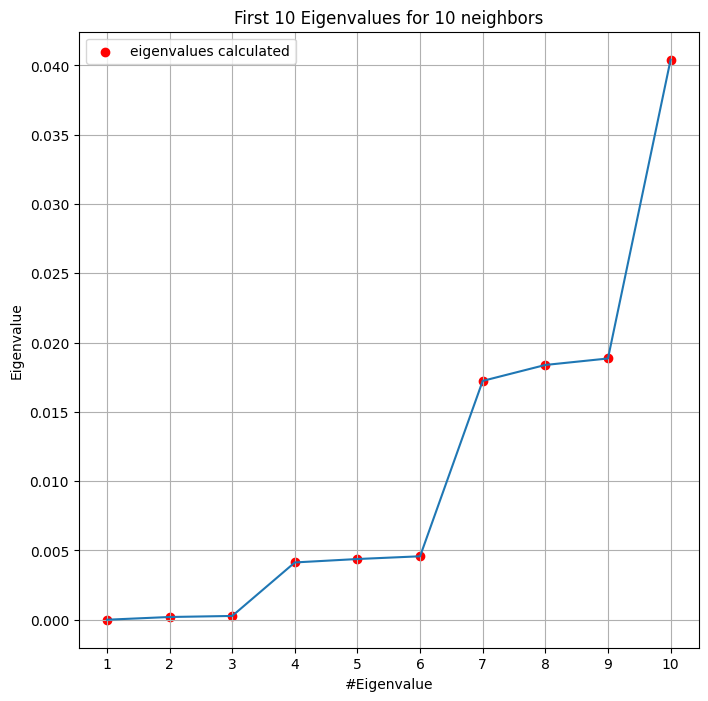

In [732]:
printEigenValues(eigenvalues, legendText='eigenvalues calculated')

Visualizing the eigenvectors

In [733]:
display(pd.DataFrame(U, index=[f'x[{i}, j]' for i in range(1, U.shape[0]+1)], columns=[f'x{i+1}' for i in range(U.shape[1])], dtype=np.float32)) 

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
"x[1, j]",0.056614,0.051534,-0.047855,-0.012185,-0.203806,-0.022246,-0.197189,-0.002040,-0.015670,-0.197036
"x[2, j]",0.056614,0.051530,-0.047870,-0.012137,-0.202949,-0.022138,-0.193784,-0.002017,-0.015407,-0.188973
"x[3, j]",0.056614,0.051528,-0.047915,-0.012070,-0.201750,-0.021982,-0.188926,-0.001996,-0.015058,-0.177569
"x[4, j]",0.056614,0.051527,-0.047993,-0.011970,-0.199977,-0.021750,-0.181749,-0.001971,-0.014556,-0.160966
"x[5, j]",0.056614,0.051525,-0.048081,-0.011849,-0.197810,-0.021470,-0.173124,-0.001936,-0.013944,-0.141448
...,...,...,...,...,...,...,...,...,...,...
"x[308, j]",0.056614,-0.080981,-0.014216,-0.085149,0.002978,0.003339,0.002127,0.073389,-0.031529,-0.005869
"x[309, j]",0.056614,-0.080981,-0.014216,-0.085157,0.002978,0.003339,0.002128,0.073421,-0.031543,-0.005874
"x[310, j]",0.056614,-0.080981,-0.014216,-0.085166,0.002979,0.003340,0.002129,0.073453,-0.031557,-0.005880
"x[311, j]",0.056614,-0.080982,-0.014216,-0.085178,0.002979,0.003340,0.002130,0.073499,-0.031578,-0.005888


Independently from the method chosen, as expected, the first $3$ eigenvalues are $0$ or are really close to $0$. <br>
Then there is another group of $3$ eigenvalues with values closer to $0.005$ which indicates a fairly weak connection between the three main components. <br>
Moreover there is, also, another group of $3$ eigenvalues, with values higher than the previous one.<br>
Finally, we can see how, starting from the $10^{th}$ eigenvalue, they become bigger and bigger, thus indicating an even stronger connection. 

# <b>6 - CLUSTERING $U$</b>

For $i = 1, ..., N$ let $y_i \in R^M$ be the vector corresponding to the $i-th$ row of $U$.
<br> Cluster the points $i = 1, ..., N \text{  } y_i\in R^M$ with the <em>k-means algorithm</em> into clusters $C_1, ..., C_M$

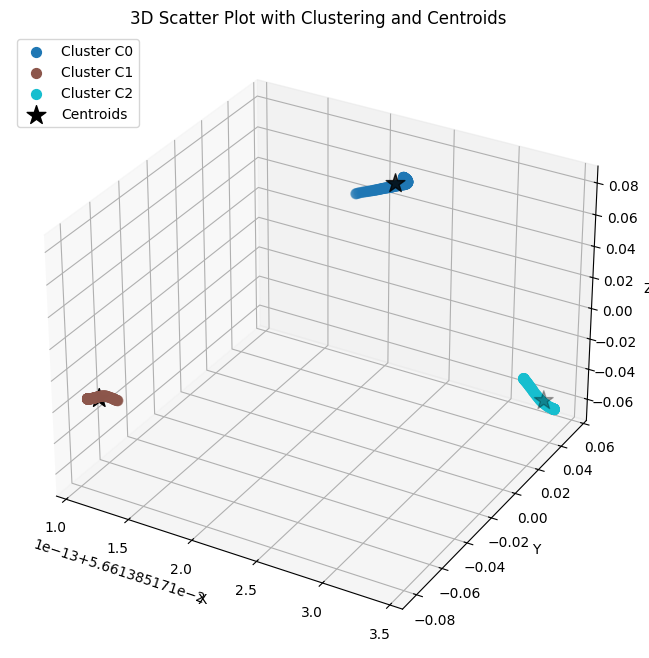

In [734]:
def plotClusteringAndCentroidsOfU(U: np.ndarray, centroids: np.ndarray, clusterLabels: np.ndarray) -> None:
    """
    This function visualizes the clustering results by plotting data points colored by their
    cluster assignments and the centroids of each cluster. It automatically determines whether
    to create a 2D or 3D plot based on the dimensionality of the input data.

    Parameters:
    U (np.ndarray): The data points to be plotted. Each row represents a point, and the number
                    of columns (2 or 3) determines whether a 2D or 3D plot is created.
    centroids (np.ndarray): The coordinates of the cluster centroids. Should have the same
                            number of columns as U.
    clusterLabels (np.ndarray): An array of cluster labels for each point in U.
    """
    
    if U.shape[1] == 3:  
        ax = plt.figure(figsize=(10, 8)).add_subplot(111, projection='3d')
        
        for label, color in zip(np.unique(clusterLabels), plt.cm.tab10(np.linspace(0, 1, len(np.unique(clusterLabels))))):
            ax.scatter((points:=U[clusterLabels == label])[:, 0], points[:, 1], points[:, 2], c=[color], s=50, label=f'Cluster C{label}')

        ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='black', marker='*', s=200, label='Centroids')
        ax.set_zlabel('Z')  
    else:
        fig, ax = plt.subplots(1,1, figsize=(8,8))
        for label, color in zip(np.unique(clusterLabels), plt.cm.tab10(np.linspace(0, 1, len(np.unique(clusterLabels))))):
            ax.scatter((points:=U[clusterLabels == label])[:, 0], points[:, 1], c=[color], s=50, label=f'Cluster C{label}')

        ax.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='*', s=200, label='Centroids')

    # Titles and labels
    ax.set_title('3D Scatter Plot with Clustering and Centroids')
    ax.set_xlabel('X'),ax.set_ylabel('Y')

    # Add legend
    ax.legend(loc='upper left')
    plt.show()

# Example Data and Usage
bestNumberOfEig = 3

km = KMeans(n_clusters=bestNumberOfEig, tol=EPS, random_state=23)
clusterLabels = km.fit_predict(U[:, :bestNumberOfEig])

plotClusteringAndCentroidsOfU(U[:, :bestNumberOfEig], centroids, clusterLabels) if 2<= (centroids:=km.cluster_centers_).shape[1]<=3 else None

# <b>7- ASSIGNING CLUSTER TO THE POINTS</b>

Assign the original points in $X$ to the same clusters as their corresponding
rows in $U$ and construct the clusters $A_1, ..., A_M$ with $A_i = \{x_j : y_j \in C_i\}$.


In [735]:
data['k-means']=clusterLabels

# <b> 8 - PLOTTING CLUSTERS </b>

Plot the clusters of points $X$ with different colors

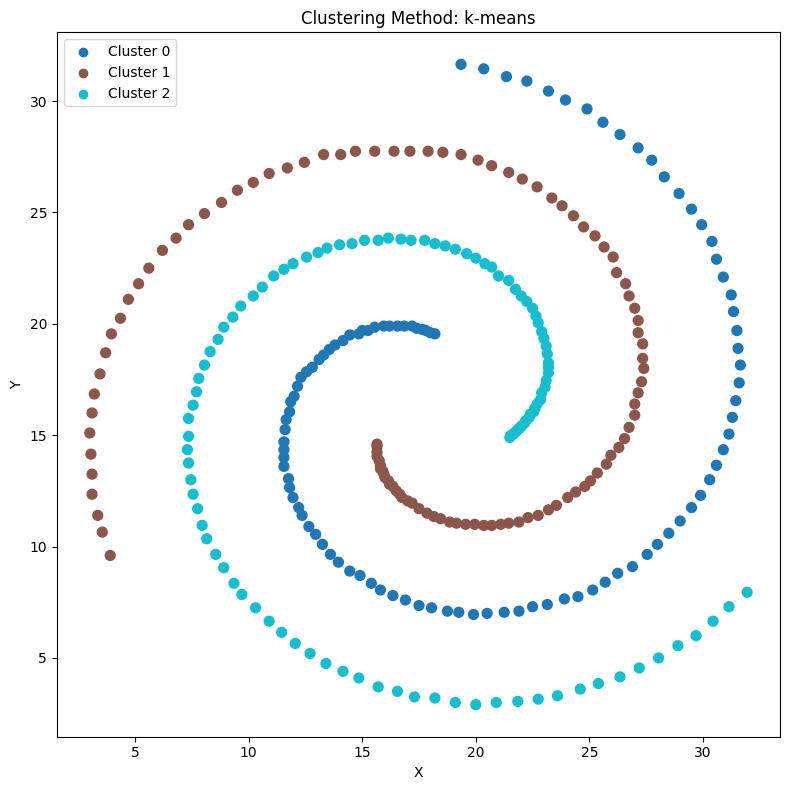

In [736]:
def plotClusteringResults(df: pd.DataFrame) -> None:
    """
    Plots the clustering results for each method in the input DataFrame.

    Parameters:
    df (pd.DataFrame): A DataFrame containing the clustering results. Each column represents a clustering method,
                       and each row represents a data point. The DataFrame should have columns 'x' and 'y' representing
                       the coordinates of the data points.
    """
    columns: np.ndarray = df.columns.difference(['x', 'y', 'cluster']).sort_values()

    # Create subplots for each clustering method
    fig, ax = plt.subplots(columns.shape[0], 1, figsize=(8, 8 * columns.shape[0]))
    ax = ax if len(columns) >1 else [ax]

    for i, column in enumerate(columns):
        scalarMap = cm.ScalarMappable(norm=colors.Normalize(vmin=min(unique_labels:=np.unique(df[column])), vmax=max(unique_labels)), 
                                        cmap=plt.get_cmap('tab10', len(unique_labels)))

        ax[i].scatter(df['x'],df['y'], c=[scalarMap.to_rgba(label) for label in df[column]],s=50)

        for label in unique_labels:
            ax[i].scatter([], [], color=scalarMap.to_rgba(label), label=f'Cluster {label}')

        ax[i].set_title(f'Clustering Method: {column}')
        ax[i].set_xlabel('X'), ax[i].set_ylabel('Y')
        ax[i].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plotClusteringResults(data)

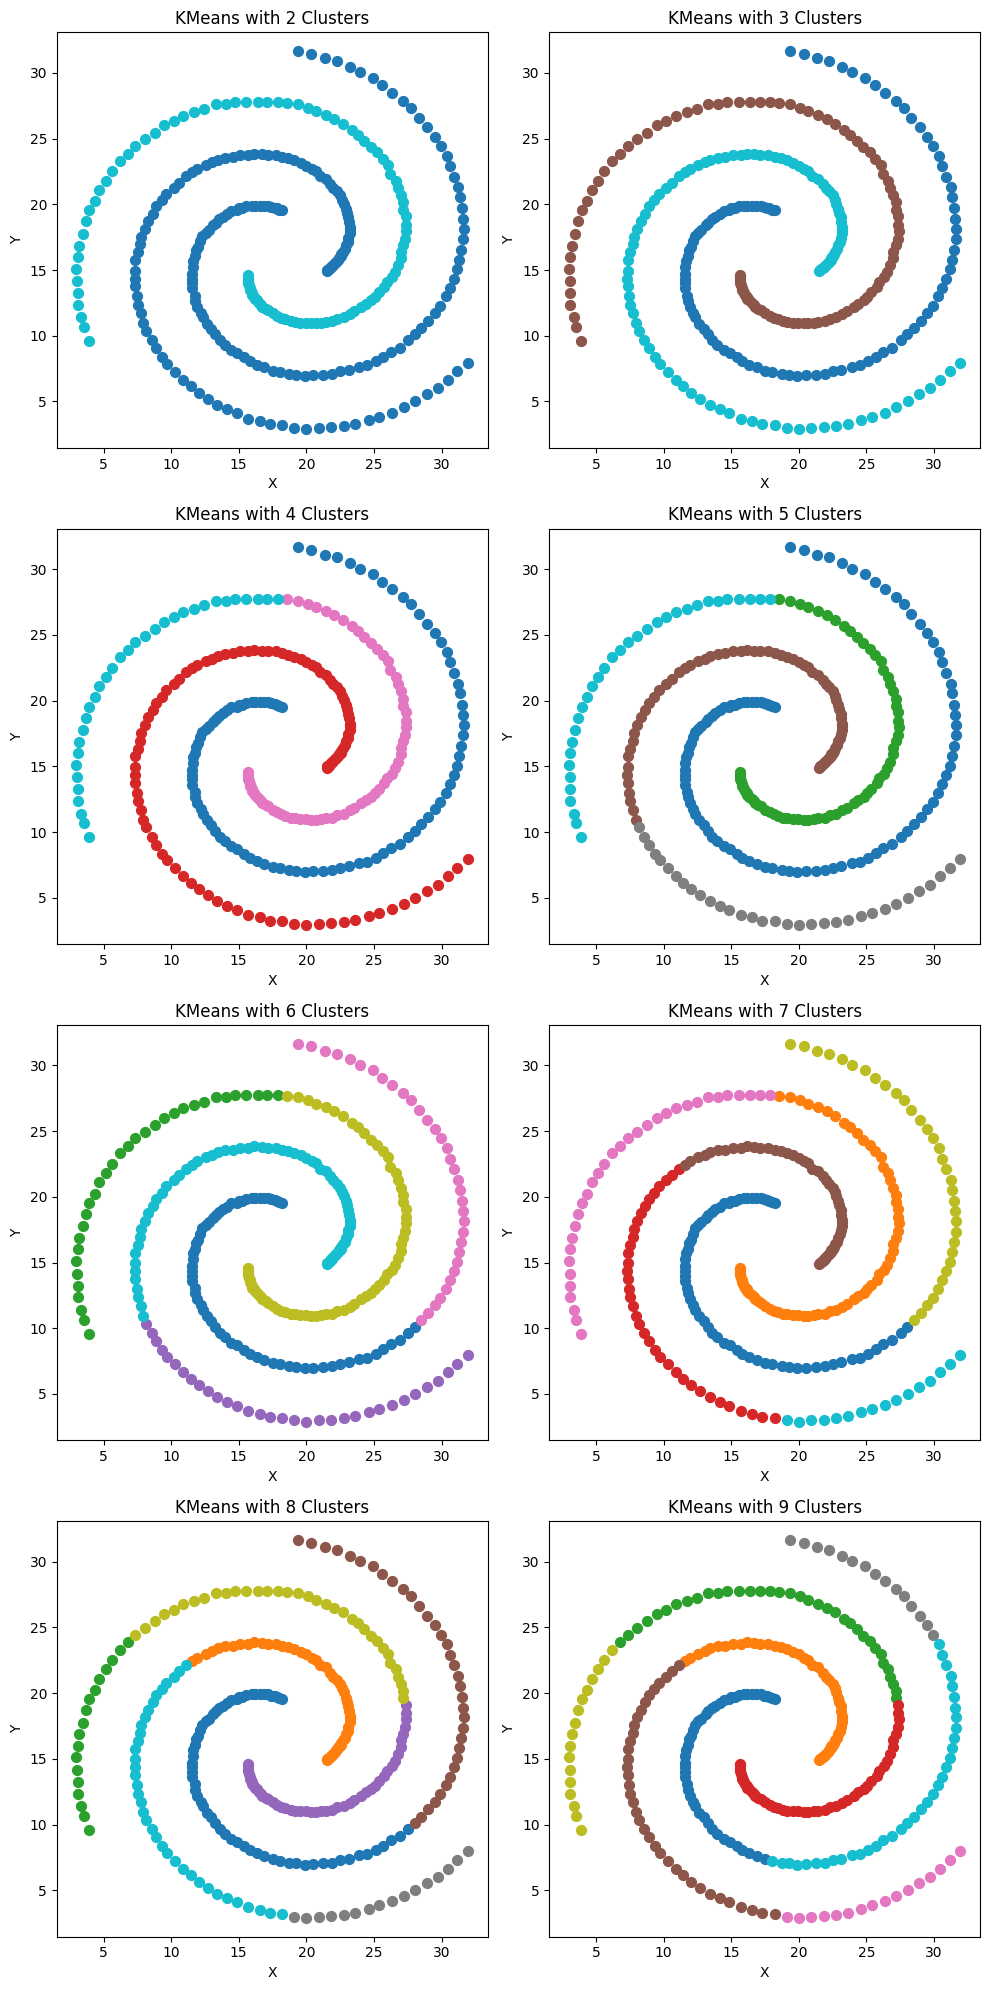

In [737]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
axes = axes.ravel()  

silhouette = np.zeros(shape=(maxCluster:=15)-2, dtype=np.float32)

for i in range(2, maxCluster):  
    km = KMeans(n_clusters=i, tol=EPS, random_state=23)
    
    if i < 4*2 +2:
        for label, color in zip(unique_labels := np.unique(clusterLabels := km.fit_predict(U[:, :i])), 
                                plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))):
            axes[i-2].scatter((points:=data[clusterLabels == label].values)[:, 0], points[:, 1], c=[color], s=50)
        
        axes[i-2].set_title(f'KMeans with {i} Clusters')
        axes[i-2].set_xlabel('X'), axes[i-3].set_ylabel('Y')
        
    silhouette[i-2] = silhouette_score(U[:, :i], clusterLabels)


# Adjust layout and show
plt.tight_layout()
plt.show()

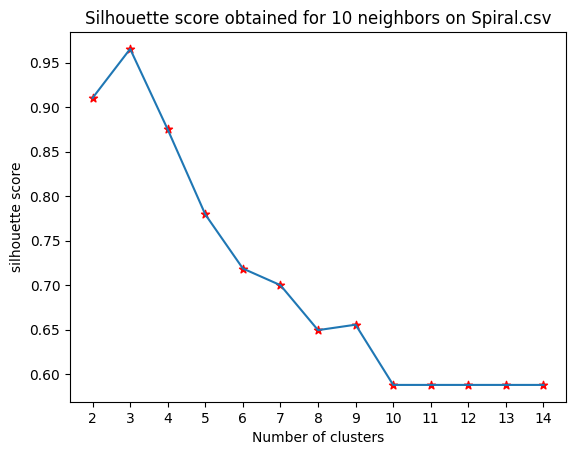

In [738]:
plt.plot(range(2,silhouette.shape[0]+2), silhouette)
plt.scatter(range(2, silhouette.shape[0]+2), silhouette, marker='*', color='red')
plt.xlabel('Number of clusters')
plt.ylabel('silhouette score')
plt.xticks(range(2,silhouette.shape[0]+2))
plt.title(f'Silhouette score obtained for {NEIGHBORS} neighbors on ' + ('Spiral.csv' if USE_SPIRAL else 'Circle.csv'));

If we are working with $spiral.csv$ we are also given the labels of the cluster, and as such we can see the accuracy of the prediction <br>
we can compute that as $\frac{1}{N} \sum_{k=1}^{N} \delta(\text{label predicted }= \text{true label})$ 

In [739]:
if USE_SPIRAL:
    print(f' Final accuracy score = {accuracy_score(y_true=data["cluster"], y_pred=list(map(lambda x: {1:2, 0:1, 2:3}[x], KMeans(n_clusters=3, tol=EPS, random_state=23).fit_predict(U[:, :3]))))*100} %')

 Final accuracy score = 100.0 %


# <b>9 - CLUSTERING METHODS COMPARISON</b>

Compute the clusters for the same set of points with other clustering methods and compare the results.

In [740]:
def plotClusters(df: pd.DataFrame, labels:np, title:str|None=None) -> None:
    """
    Plots the clusters for the input DataFrame.
    
    Parameters:
    df (pd.DataFrame): A DataFrame containing the coordinates of the data points.
    labels (np.ndarray): An array containing the labels assigned to each data point.
    title (str|None): The title of the plot. Defaults to None.
    """
    plt.figure(figsize=(10, 8))
    for label in np.unique(labels):
        plt.scatter(df[labels == label]['x'],df[labels == label]['y'], label=f'Cluster {label}' if label != -1 else 'Noise',s=50)
    
    # Add legend and axis labels
    plt.title(f'Clustered Points {title or " "}')
    plt.xlabel('X'), plt.ylabel('Y')
    plt.legend(loc='upper right', title='Clusters')
    plt.show()

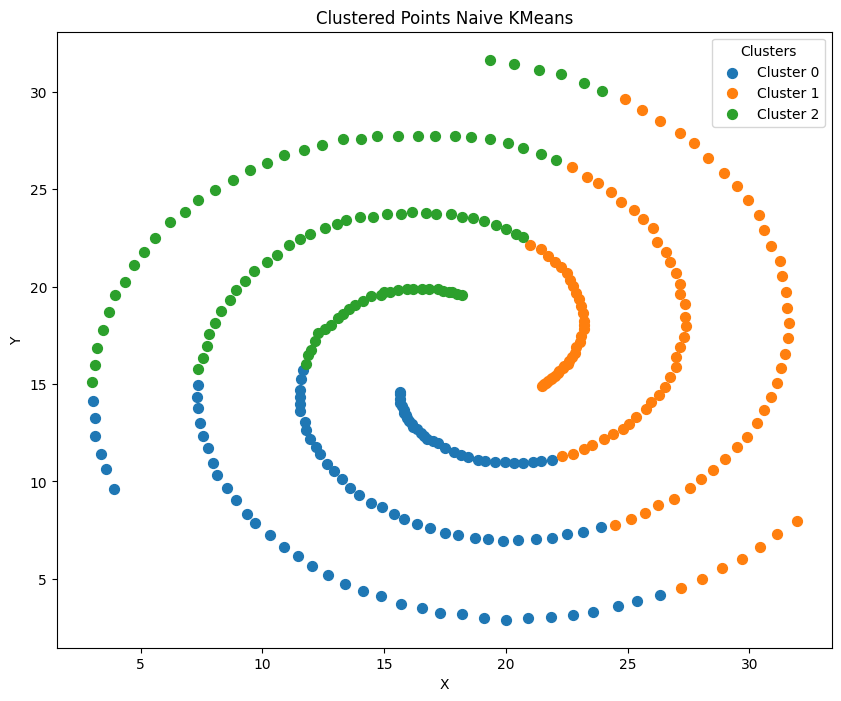

In [741]:
plotClusters(data[['x', 'y']], KMeans(n_clusters=3, random_state=23).fit_predict(data[['x', 'y']]), 'Naive KMeans')

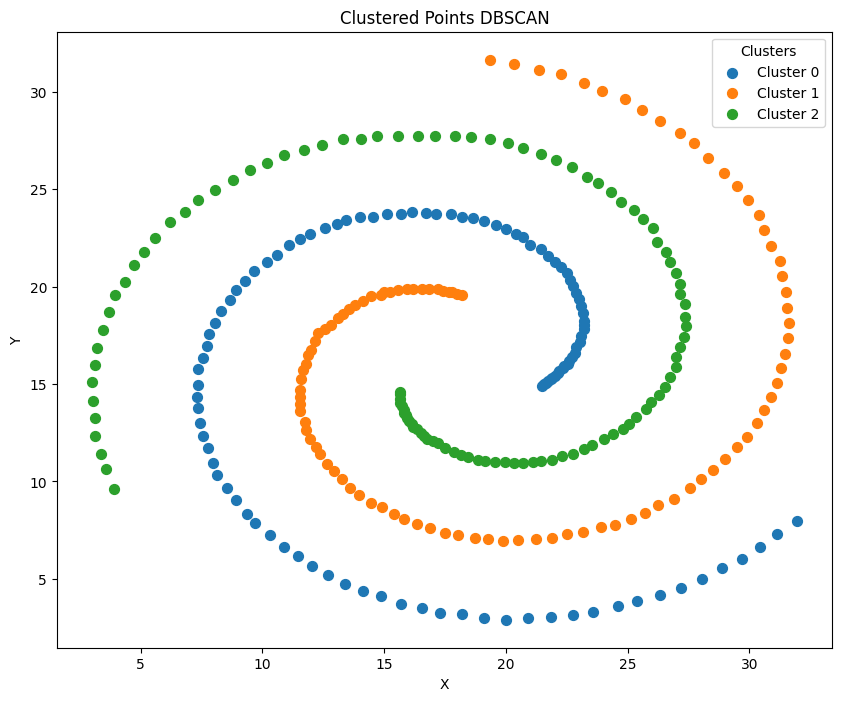

In [742]:
# for spiral eps=1.2, min_samples=3
# for circle eps=0.8 min_samples=3 with 3 clusters
# for circle eps=0.85 min_samples=3 with 2 clusters
plotClusters(data[['x', 'y']], DBSCAN(eps=1.2 if USE_SPIRAL else 0.85, min_samples=3).fit_predict(data[['x','y']]), 'DBSCAN')


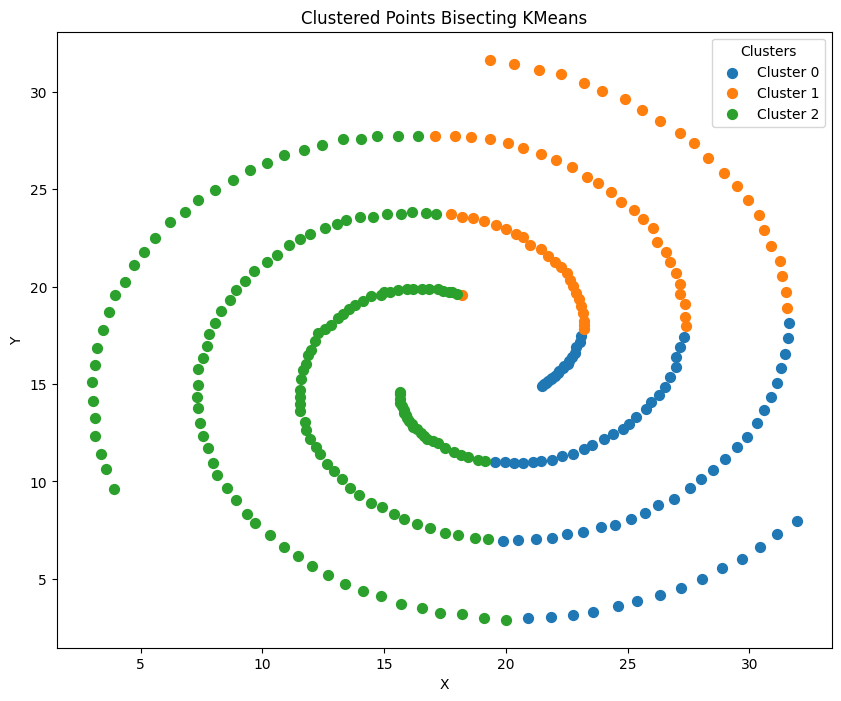

In [743]:
plotClusters(data[['x', 'y']], BisectingKMeans(n_clusters=3).fit_predict(data[['x','y']]), title='Bisecting KMeans')

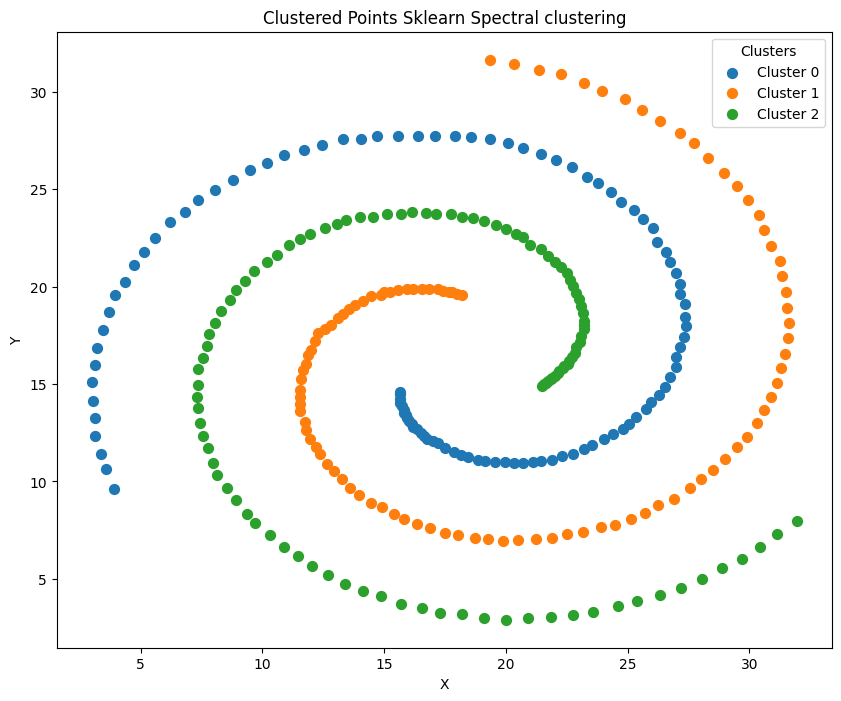

In [744]:
# nearest_neighbors
plotClusters(data[['x', 'y']], 
             SpectralClustering(n_clusters=3, random_state=23, n_init=20, gamma=0.5, 
                                affinity='rbf', n_neighbors=NEIGHBORS, eigen_tol=1e-6, n_jobs=-1).fit_predict(data[['x','y']]), 
             title='Sklearn Spectral clustering')

# <b>USING 3D DATA</b>

We can load the 3D dataset, it has the following components:
<ol>
<li><b>x</b>: the x axis coordinate</li>
<li><b>y</b>: the y axis coordinate</li>
<li><b>z</b>: the z axis coordinate</li>
<li><b>cluster</b>: the true cluster value for the point</li>
</ol>

Moreover, it has $N = 3000$ points

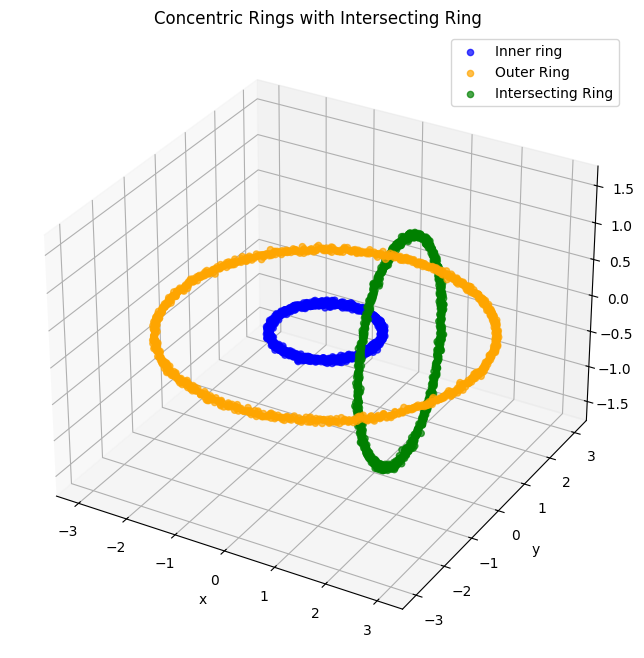

In [745]:
df = pd.read_csv(filepath_or_buffer=RINGS_3D_INPUT_FILE, header=0)

ax = plt.figure(figsize=(10, 8)).add_subplot(111, projection='3d')

for i, (labels, color) in enumerate(zip(['Inner ring', 'Outer Ring', 'Intersecting Ring'],  ['blue', 'orange', 'green'])):
    ax.scatter((temp := df[df['cluster']==i].values)[:, 0], temp[:, 1], temp[:, 2], label=labels, alpha=0.7, c=color)

ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z")
ax.legend()
ax.set_title("Concentric Rings with Intersecting Ring")
plt.show()

## <b>BUILDING $W$, $D$ AND $L$</b>

As previously done, we can build the similarity matrix $W$ using the same similarity function, <br>
then we can build the degree matrix $D$ and finally the Laplacian matrix $L$.

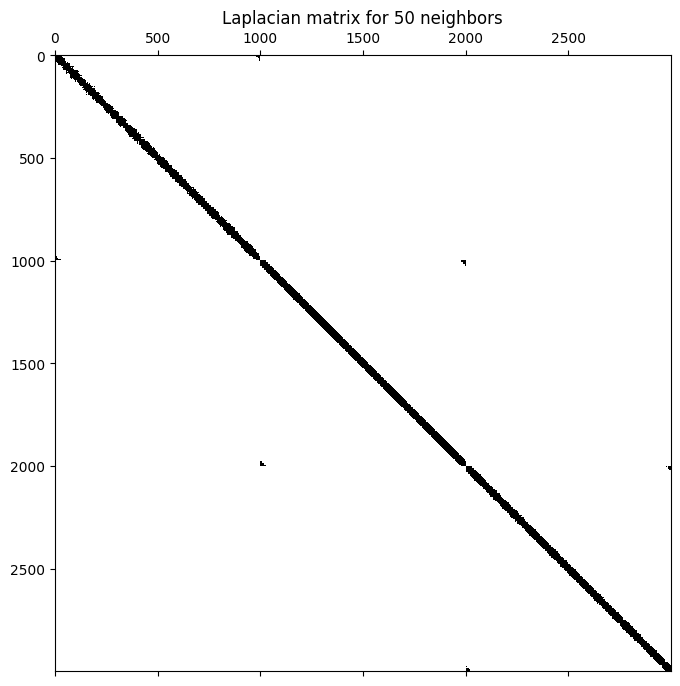

In [746]:
plt.subplots(1,1,figsize=(8,8))
plt.spy(L:=buildLaplacianMatrix(buildDegreeMatrix(W:=buildSimilarityMatrix(df, 50)), W, computeNormalizedLaplacian=False));
plt.title('Laplacian matrix for 50 neighbors');

As we can see from the plot, there are mainly $3$ connected components forming the graph

## <b>PLOTTING EIGENVALUES</b>

We can plot the first $10$ eigenvalues of $L$

Computed the following 10 eigenvalues


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

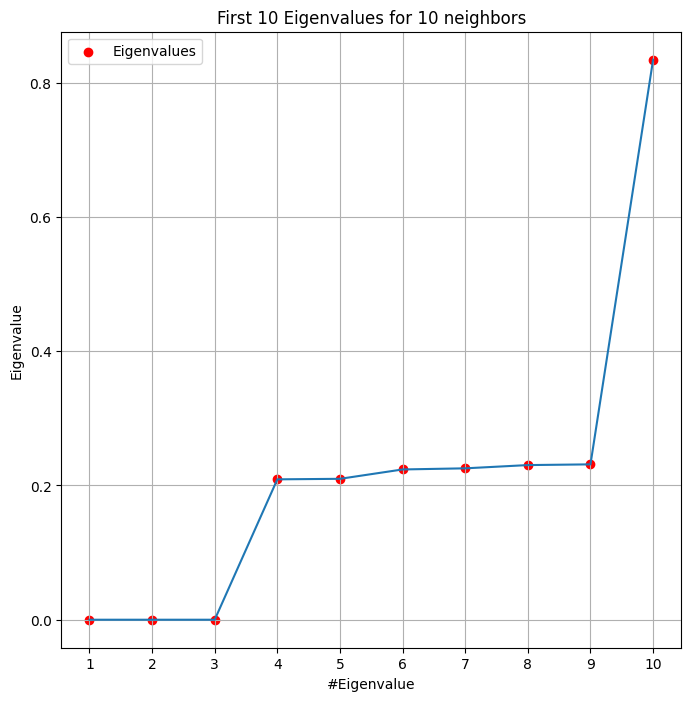

In [747]:
eigVal, U= computeEigenpairs(L, numEig=10)
printEigenValues(eigVal, 'Eigenvalues')

The first $3$ eigenvalues are approximately $0$, as such we can think of using the first $3$ eigenvectors to compute the matrix U, moreover we can also try using $3$ cluster centers when it comes to cluster the data.<br>
We can also try, mainly to comment on the results, to cluster the data using a number of cluster anywhere in the range $[3, 9]$. 

## <b>CLUSTERING </b>

Initially, we try creating a cluster of the results using a $3$ cluster centers using the <em>K-Means</em> algorithm.

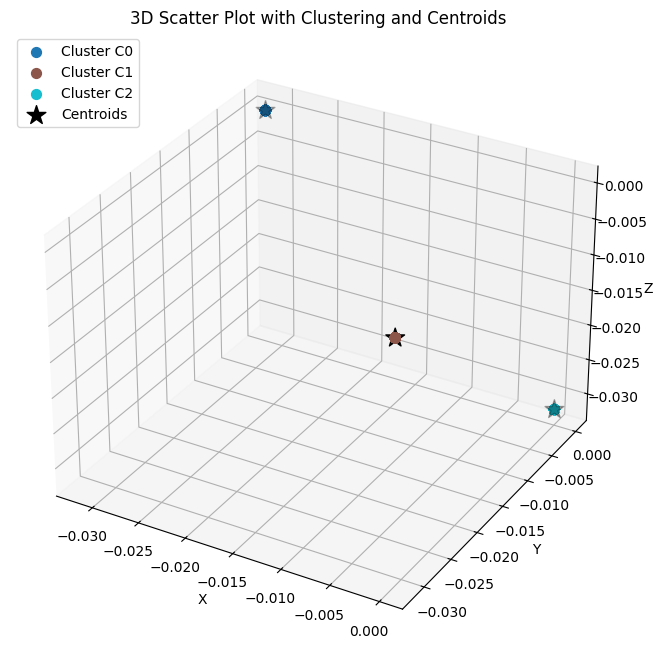

In [748]:
centr = 3

km = KMeans(n_clusters=centr, tol=EPS, random_state=23)
clusterLabels = km.fit_predict(U[:, :centr])

plotClusteringAndCentroidsOfU(U[:, :centr], centroids, clusterLabels) if 2<= (centroids:=km.cluster_centers_).shape[1]<=3 else None

## <B>PLOTTING THE RESULTS</B>

We can now plot the obtained clustering results

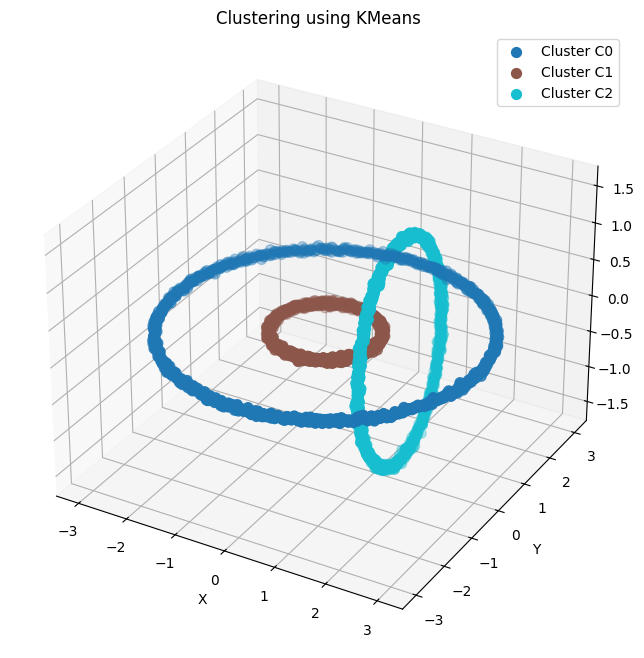

In [749]:
def plot3DCluster(df:pd.DataFrame, clusterLabels:np, algorithm:str)->None:
    """Plot the cluster results using 3D scatter plot. 
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the coordinates of the data points.
        clusterLabels (np.ndarray): An array containing the labels assigned to each data point.
        algorithm (str): The algorithm used for clustering.
    """
    ax = plt.figure(figsize=(10, 8)).add_subplot(111, projection='3d')

    for label, color in zip(np.unique((clusterLabels)), 
                            plt.cm.tab10(np.linspace(0, 1, len(np.unique(clusterLabels))))):        
        ax.scatter((points:=df[clusterLabels == label].values)[:, 0], points[:, 1], points[:, 2], c=[color], s=50, label=f'Cluster C{label}')
        
    ax.set_title(f'Clustering using {algorithm}')
    ax.set_xlabel('X'),ax.set_ylabel('Y'),ax.set_zlabel('Z')
    ax.legend(loc='best');


plot3DCluster(df, clusterLabels, 'KMeans')

The clustering performs quite well, managing to effectively create the wanted clustering. 

## <b>TRYING OTHER NUMBER OF CLUSTERS</b>

We will try to cluster the points using a different number of clusters.

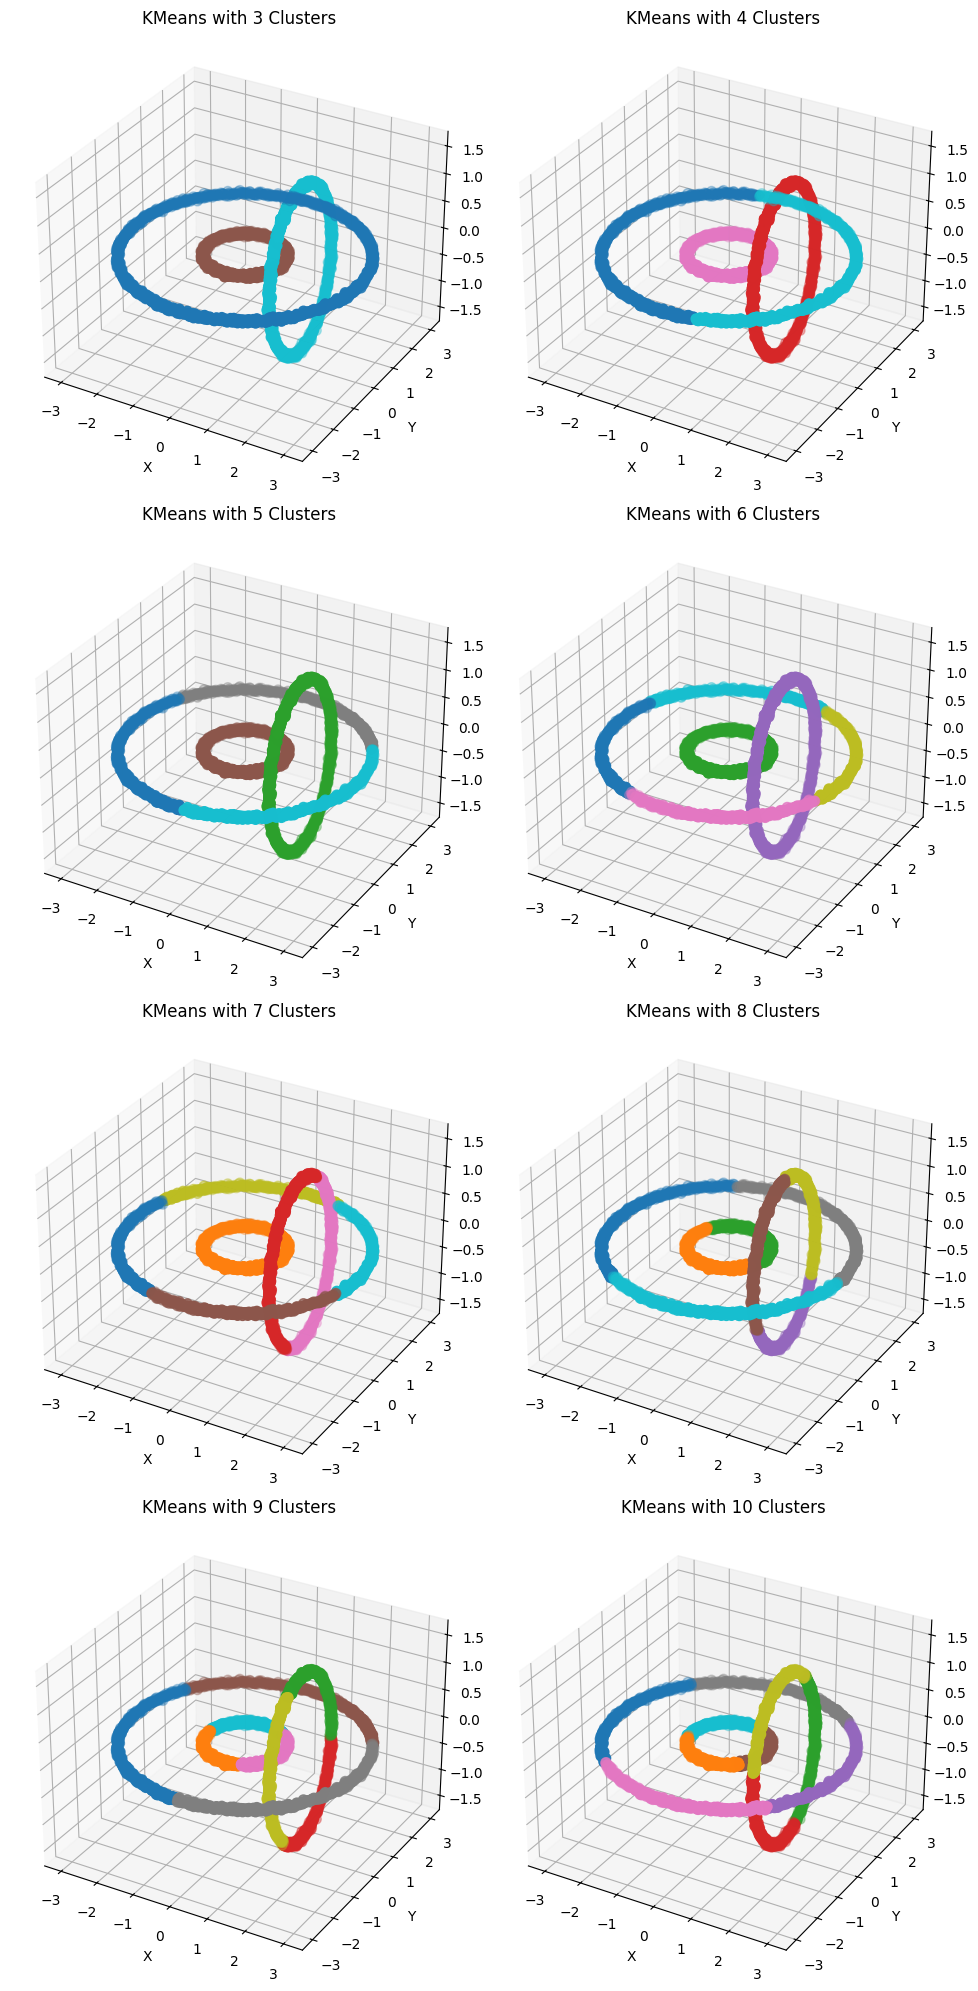

In [750]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20), subplot_kw={'projection': '3d'})
axes = axes.ravel()  

silhouette = np.zeros(shape=(maxCluster:=15)-3, dtype=np.float32)

for i in range(3, maxCluster):  
    km = KMeans(n_clusters=i, tol=EPS, random_state=23)
    
    if i < 4*2 +3:
        for label, color in zip(unique_labels := np.unique(clusterLabels := km.fit_predict(U[:, :i])), 
                                plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))):
            axes[i-3].scatter((points:=df[clusterLabels == label].values)[:, 0], points[:, 1], points[:, 2], c=[color], s=50)
        
        axes[i-3].set_title(f'KMeans with {i} Clusters')
        axes[i-3].set_xlabel('X'), axes[i-3].set_ylabel('Y'), axes[i-3].set_zlabel('Z')
        
    silhouette[i-3] = silhouette_score(U[:, :i], clusterLabels)


# Adjust layout and show
plt.tight_layout()
plt.show()

Moreover, we can evaluate the clustering via the use of the <b>silhouette score</b>.

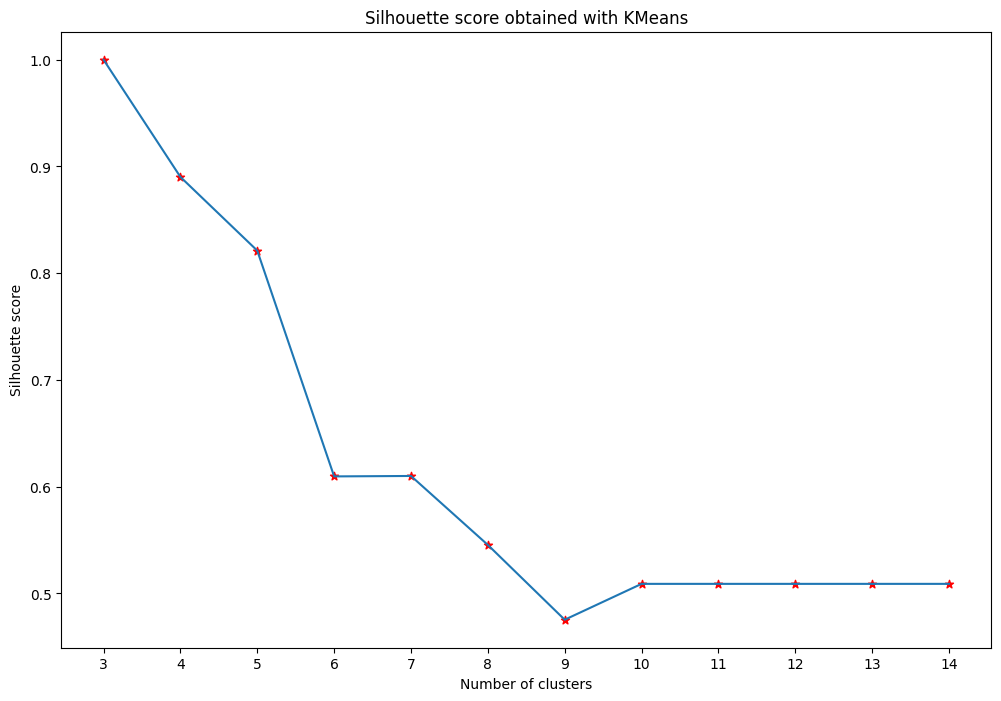

In [751]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(range(3, maxCluster), silhouette)
ax.scatter(range(3,maxCluster), silhouette, c='red', marker='*', label='scores')
ax.set_title('Silhouette score obtained with KMeans')
ax.set_xlabel('Number of clusters'), ax.set_ylabel('Silhouette score')
ax.set_xticks(list(range(3,maxCluster)));

As expected , the best silhouette score obtained is reached for $3$ clusters.<br>
Note: this is also the best silhouette score obtainable in general, since it range in the interval $[-1, 1]$.

We can also compute the final accuracy of the model and the prediction given that we have the labels.<br>
we can compute that as $\frac{1}{N} \sum_{k=1}^{N} \delta(\text{label predicted }= \text{true label})$ 

In [752]:
print(f' Final accuracy score = {accuracy_score(y_true=df["cluster"], y_pred=list(map(lambda x: {1:0, 0:1, 2:2}[x], KMeans(n_clusters=3, tol=EPS, random_state=23).fit_predict(U[:, :3]))))*100} %')

 Final accuracy score = 100.0 %


## <b> COMPARISON WITH OTHER CLUSTERING METHODS</b>

Finally, we will do a quick comparison with other clustering methods, moreover we use:
<ul>
<li>Our implementation of the spectral clustering with KMeans</li>
<li>KMeans alone</li>
<li>Bisecting KMeans</li>
<li>DBSCAN</li>
<li>Scikit-learn implementation of the spectral clustering</li>
</ul>
We will use a different number of clusters (when possible), and evaluate by means of the silhouette score.

### <b> FINE TUNED DBSCAN </b>

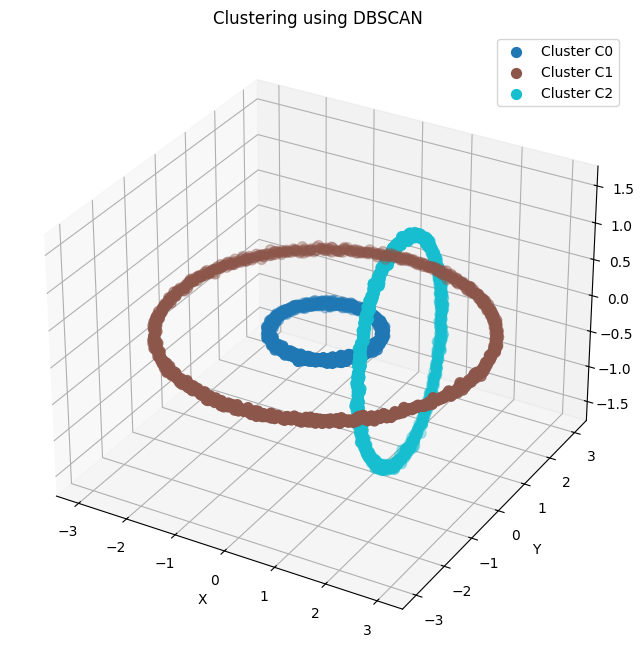

In [753]:
plot3DCluster(df[['x','y','z']], DBSCAN(min_samples=8, eps=0.2, n_jobs=-1).fit_predict(df[['x', 'y', 'z']]), 'DBSCAN')

### <B> FINE TUNED KMEANS </b>

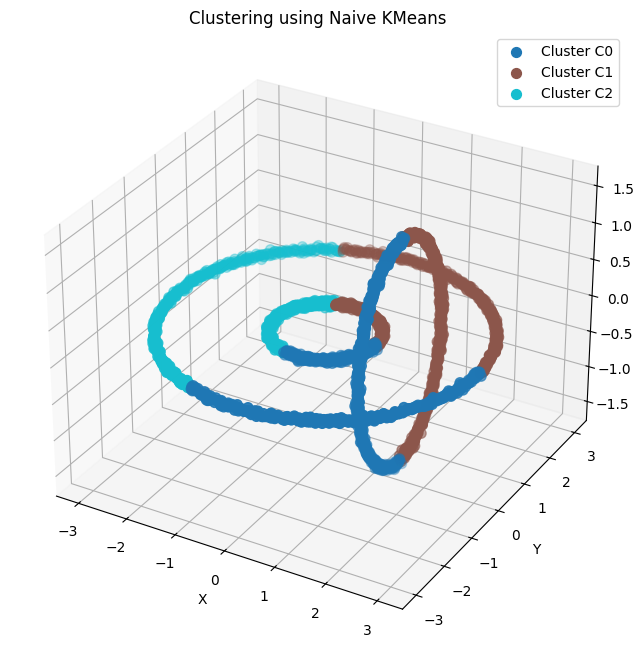

In [754]:
plot3DCluster(df[['x','y','z']], KMeans(n_clusters=3).fit_predict(df[['x','y','z']]), 'Naive KMeans')

### <B> FINE TUNED BISECTING KMEANS </b>

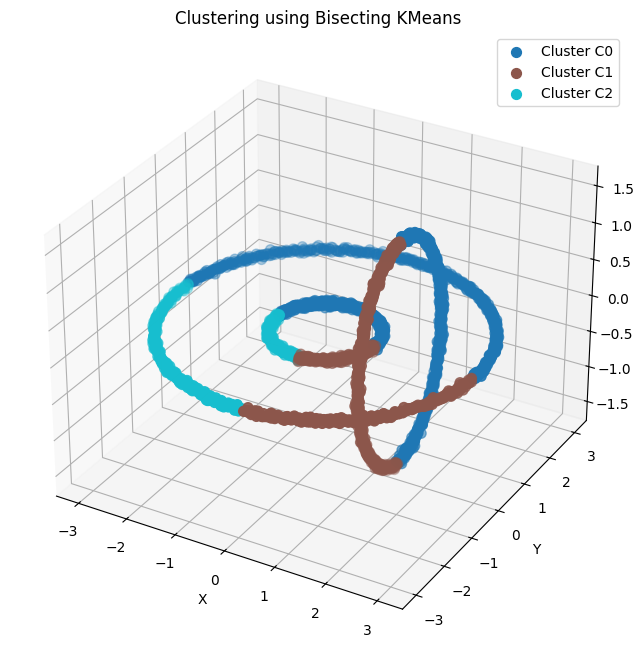

In [755]:
plot3DCluster(df[['x', 'y', 'z']], BisectingKMeans(n_clusters=3).fit_predict(df[['x','y','z']]), 'Bisecting KMeans')

### <B> FINE TUNED SPECTRAL CLUSTERING </b>

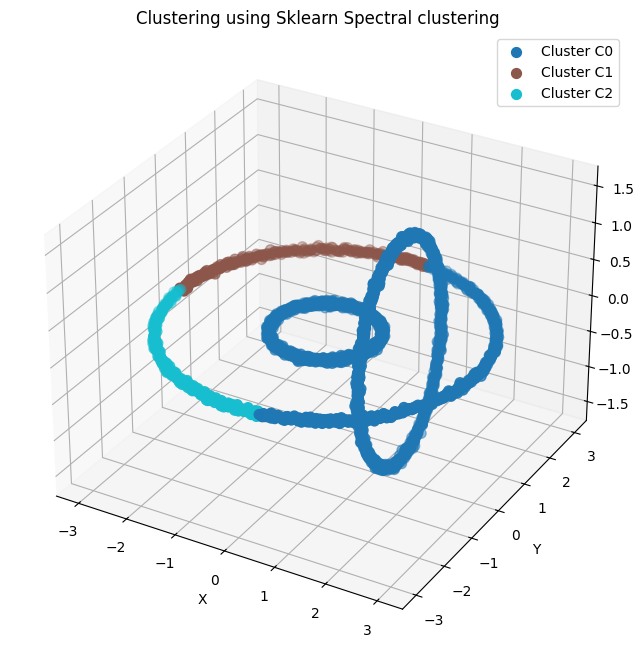

In [756]:
plot3DCluster(df[['x', 'y', 'z']], 
             SpectralClustering(n_clusters=3, random_state=23, n_init=30, gamma=0.5, 
                                affinity='rbf', n_neighbors=50, eigen_tol=1e-8, n_jobs=-1).fit_predict(df[['x','y','z']]), 
            'Sklearn Spectral clustering')

### <B> FINE TUNED KMEANS, BISECTING KMEANS, SPECTRAL CLUSTERING </b>

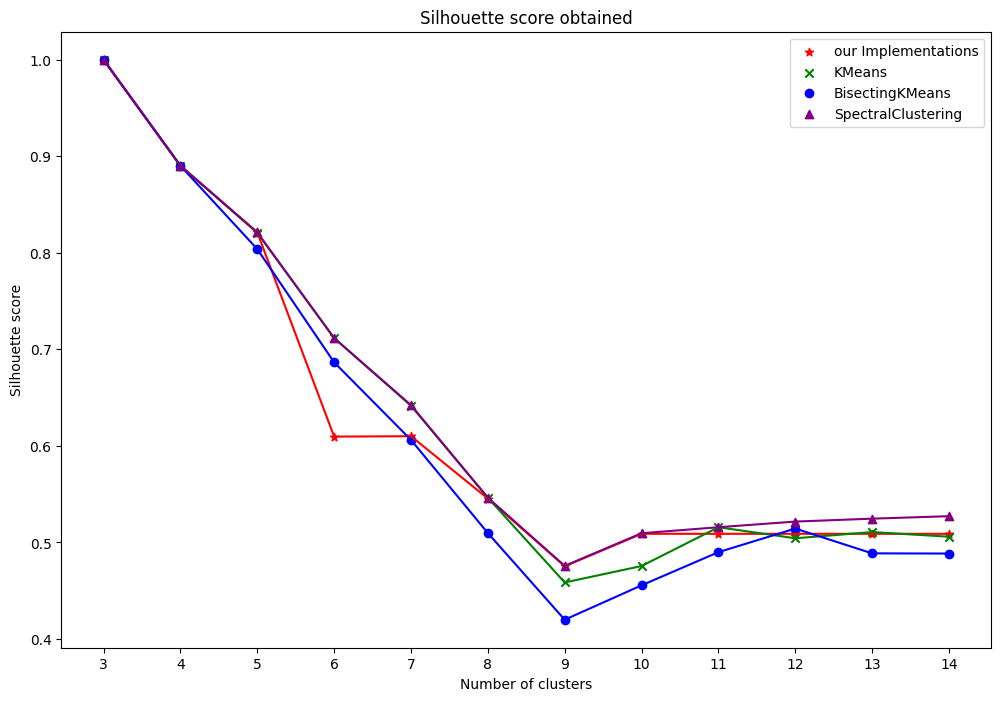

In [757]:
def showDownOfMethods(U:np, maxCluster:int=11)-> dict[str:np]:  
    """Show the silhouette scores obtained by different clustering methods.
    
    Parameters:
    U (np.ndarray): The coordinates of the data points.
    maxCluster (int): The maximum number of clusters.
    
    Returns:
    dict[str:np]: A dictionary containing the silhouette scores for each clustering method.
    """
    results = {
        'KMeans':np.zeros(shape=(maxCluster-3), dtype=np.float32) - 1,
        'BisectingKMeans':np.zeros(shape=(maxCluster-3), dtype=np.float32) - 1,
        'SpectralClustering':np.zeros(shape=(maxCluster-3), dtype=np.float32) - 1
    }
        
    for i in range(3, maxCluster):
        for key in (clustering := {
            'KMeans':KMeans(n_clusters=i, tol=EPS),
            'BisectingKMeans':BisectingKMeans(n_clusters=i, tol=EPS),
            'SpectralClustering':SpectralClustering(n_clusters=i,n_components=i,random_state=23, gamma=0.5,
                                                    affinity='rbf', n_neighbors=50, eigen_tol=EPS, n_jobs=-1)
                                        }):    
            results[key][i-3] = silhouette_score(U[:, :i], clustering[key].fit_predict(U[:, :i])) 
            
    return results

fig, ax = plt.subplots(1,1,figsize=(12,8))

for (key, color, marker) in zip(
        (stats := {'our Implementations':silhouette} | showDownOfMethods(U, maxCluster)),
        ['red', 'green', 'blue', 'purple'], ['*', 'x', 'o', '^']):
    ax.plot(range(3, maxCluster), stats[key], color=color)
    ax.scatter(range(3,maxCluster), stats[key], c=color, marker=marker, label=key)
    
ax.legend()
ax.set_xticks(list(range(3, maxCluster)))
ax.set_xlabel('Number of clusters'), ax.set_ylabel('Silhouette score')
ax.set_title('Silhouette score obtained');